In [ ]:
import numpy as np

import torch 
from torchvision import datasets, transforms

from pyhessian_mod import hessian # Hessian computation

from utils_pyh import * # get the dataset

from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt

import sys

sys.path.append("../")
import cifar.models

import copy

%matplotlib inline

In [2]:
parent1 = cifar.models.VGG('VGG11', 10, batch_norm=False, bias=False, relu_inplace=True)
parent2 = cifar.models.VGG('VGG11', 10, batch_norm=False, bias=False, relu_inplace=True)
fusion = cifar.models.VGG('VGG11', 10, batch_norm=False, bias=False, relu_inplace=True)

in _make_layers [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [3]:
sum(p.numel() for p in parent1.parameters())

9222848

In [4]:
state1 = torch.load("../cifar_models/non_pruning/model_0/best.checkpoint", map_location=torch.device('cpu'))
state2 = torch.load("../cifar_models/non_pruning/model_1/best.checkpoint", map_location=torch.device('cpu'))
state3 = torch.load("../cifar_models/non_pruning/fusion_retraining/best.checkpoint", map_location=torch.device('cpu'))

In [5]:
parent1.load_state_dict(state1['model_state_dict'])
parent2.load_state_dict(state2['model_state_dict'])
fusion.load_state_dict(state3['model_state_dict'])

<All keys matched successfully>

In [6]:
criterion = torch.nn.CrossEntropyLoss()
BATCH_SIZE = 4

test_loader = torch.utils.data.DataLoader(
                datasets.CIFAR10('../data/', train=False, download=True,
                                           transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(
                                                   # (mean_ch1, mean_ch2, mean_ch3), (std1, std2, std3)
                                                   (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ])),
                batch_size = BATCH_SIZE, shuffle=True
            )


Files already downloaded and verified


In [7]:
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        # print("param: ", m_orig.data.shape)
        # print("direction: ", d.shape)
        m_perb.data = m_orig.data + alpha * d
    return model_perb

def param_landscape_hessian_eig(models, loader):
    # lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
    lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)
    labels = ["parent1", "parent2", "fusion"]


    eigenvalues = {}
    traces = {}
    loss_landscape = {'lambdas': lams.tolist()}

    for k, (inputs, targets) in enumerate(loader):
        if k >= 2: break
        
        eigenvalues[f"batch_{k}"] = {}
        traces[f"batch_{k}"] = {}
        loss_landscape[f"batch_{k}"] = {}
        
        for i, model in enumerate(models):

            hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=False) # cuda=True
            trace = hessian_comp.trace()

            top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=3)
            loss_list = []
            
            # create a copy of the model
            model_perb = copy.deepcopy(model)
            model_perb.eval()
            # model_perb = model_perb.cuda()

            for lam in lams:
                model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
                loss_list.append(criterion(model_perb(inputs), targets).item())
            
            eigenvalues[f"batch_{k}"][f"{labels[i]}"] = top_eigenvalues
            traces[f"batch_{k}"][f"{labels[i]}"] = np.mean(trace)
            loss_landscape[f"batch_{k}"][f"{labels[i]}"] = loss_list

    return loss_landscape, eigenvalues, traces

In [8]:
loss_landscape, eigenvalues, traces = param_landscape_hessian_eig([parent1, parent2, fusion], test_loader)

/Users/geventh/miniforge3/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1176.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [9]:
loss_landscape

{'lambdas': [-0.5,
  -0.44999998807907104,
  -0.4000000059604645,
  -0.3499999940395355,
  -0.30000001192092896,
  -0.25,
  -0.20000000298023224,
  -0.15000000596046448,
  -0.10000000149011612,
  -0.05000000074505806,
  0.0,
  0.05000000074505806,
  0.10000000149011612,
  0.15000000596046448,
  0.20000000298023224,
  0.25,
  0.30000001192092896,
  0.3499999940395355,
  0.4000000059604645,
  0.44999998807907104,
  0.5],
 'batch_0': {'parent1': [7.180062294006348,
   6.377798557281494,
   5.632600784301758,
   4.942403793334961,
   4.288632392883301,
   3.6651670932769775,
   3.061781644821167,
   2.458941698074341,
   1.8227474689483643,
   1.087181806564331,
   0.5032792687416077,
   0.4056038558483124,
   0.4205171763896942,
   0.45945465564727783,
   0.5046596527099609,
   0.5580658316612244,
   0.622391402721405,
   0.6839823722839355,
   0.7493734359741211,
   0.8153740763664246,
   0.879435122013092],
  'parent2': [2.014810800552368,
   1.8773390054702759,
   1.742082953453064,
  

In [32]:
loss_landscape

{'lambdas': array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ], dtype=float32),
 'batch_0': {'parent1': [5.4277167320251465,
   5.107799530029297,
   4.7902679443359375,
   4.476505279541016,
   4.162842273712158,
   3.830782890319824,
   3.4699811935424805,
   3.031874895095825,
   2.430997371673584,
   1.2590893507003784,
   0.02869236283004284,
   0.011274989694356918,
   0.013738101348280907,
   0.017553038895130157,
   0.02353563904762268,
   0.03367811441421509,
   0.05177689716219902,
   0.0842192992568016,
   0.13754671812057495,
   0.22482378780841827,
   0.3606117069721222],
  'parent2': [5.754079341888428,
   5.346220970153809,
   4.954519271850586,
   4.573707103729248,
   4.200482368469238,
   3.8260176181793213,
   3.4436326026916504,
   3.0408239364624023,
   2.542123556137085,
   1.623383641242981,
   0.060325488448143005,
   0.02562934346497059,
   0.0

In [18]:
loss = []
for key, value in loss_landscape.items():
    if "batch" in key:
        loss.append(list(value.values()))

print(loss)

[[[7.180062294006348, 6.377798557281494, 5.632600784301758, 4.942403793334961, 4.288632392883301, 3.6651670932769775, 3.061781644821167, 2.458941698074341, 1.8227474689483643, 1.087181806564331, 0.5032792687416077, 0.4056038558483124, 0.4205171763896942, 0.45945465564727783, 0.5046596527099609, 0.5580658316612244, 0.622391402721405, 0.6839823722839355, 0.7493734359741211, 0.8153740763664246, 0.879435122013092], [2.014810800552368, 1.8773390054702759, 1.742082953453064, 1.5998446941375732, 1.4565889835357666, 1.3170150518417358, 1.1833467483520508, 1.0463323593139648, 0.8870357871055603, 0.7181307673454285, 0.6319518685340881, 0.928098201751709, 1.4139118194580078, 1.9097671508789062, 2.4242172241210938, 2.960999011993408, 3.515146017074585, 4.088881015777588, 4.663367748260498, 5.251812934875488, 5.857595443725586], [5.916510105133057, 5.4722161293029785, 5.046283721923828, 4.638978958129883, 4.242733478546143, 3.849459409713745, 3.449442148208618, 3.0015649795532227, 2.38995623588562,

In [19]:
np.array(loss).shape

(2, 3, 21)

In [8]:
traces_np = np.array(traces)
mean_traces = traces_np.mean(axis=0)
std_traces = traces_np.std(axis=0)

In [9]:
mean_traces

array([1761.95619849, 1418.52260625, 1763.09849055])

In [10]:
evs_np = np.array(eigenvalues)
mean_evs = evs_np.mean(axis=0)
std_evs = evs_np.std(axis=0)

In [11]:
print("Parent 1:", mean_evs[0])
print("Parent 2:", mean_evs[1])
print("Fusion 3:", mean_evs[2])

Parent 1: [501.37698364 210.19102859 192.48339272]
Parent 2: [320.41966248 268.74032593 197.37796021]
Fusion 3: [621.20233154 515.56365967 273.80713654]


In [12]:
result_np = np.array(loss_landscape)
mean = result_np.mean(axis=0)
std = result_np.std(axis=0)

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

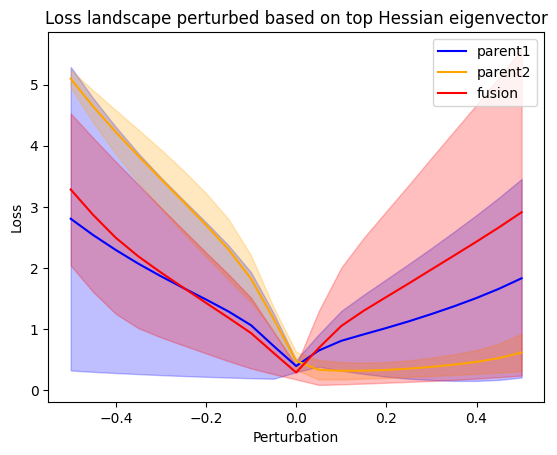

In [13]:
labels = ["parent1", "parent2", "fusion"]
colors = ["blue", "orange", "red"]
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

for i in range(mean.shape[0]):
    plt.fill_between(lams, mean[i] + std[i], mean[i] - std[i], alpha = 0.25, color = colors[i])
    plt.plot(lams, mean[i], label=labels[i], color = colors[i])

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

In [7]:
for k, (inputs, targets) in enumerate(test_loader):
        break
hessian_comp = hessian(fusion, criterion, data=(inputs, targets), cuda=False) # cuda=True

/Users/geventh/miniforge3/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1176.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [8]:
density_eigen, density_weight = hessian_comp.density()

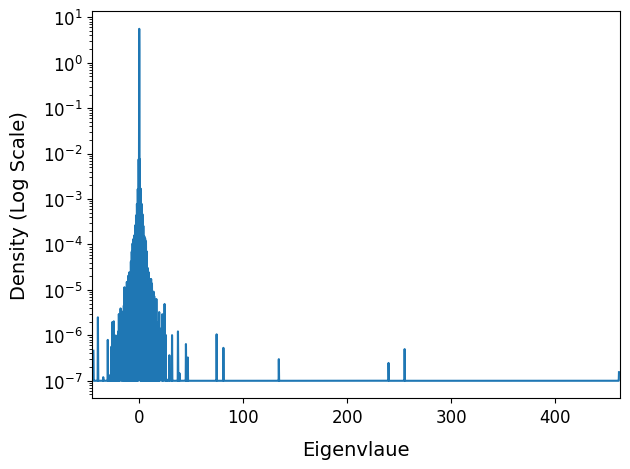

In [9]:
get_esd_plot(density_eigen, density_weight)

In [2]:
from density_plot import density_generate
import matplotlib.pyplot as plt

def plot_ev_density(eigenvalue_density, path = None):
    # Density of EVs for each model and batch
    labels = ["Parent 1", "Parent 2", "Fusion"]
    colors = ["blue", "orange", "red"]
    
    fig, axs = plt.subplots(len(eigenvalue_density), len(eigenvalue_density[0]))
    fig.tight_layout(h_pad=2)
    for i, models in enumerate(eigenvalue_density):
        for j, [density_eigen, density_weight] in enumerate(models):
            density, grids = density_generate(density_eigen, density_weight)
            axs[i, j].semilogy(density, grids + 1.0e-7, label=labels[j], color = colors[j])
            axs[i, j].set_title(f"{labels[i]} - Batch {j}")
            axs[i, j].set(xlim=(np.min(density_eigen) - 1, np.max(density_eigen) + 1), ylim=(None, None))
            # plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
            # plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
            # plt.xticks(fontsize=12)
            # plt.yticks(fontsize=12)
            # plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
            # plt.tight_layout()
    # fig.savefig(f'{path}/ev_density_plot.png')
    fig.show()

In [3]:
import json
 
f = open('./results/vgg11_nobias_Cifar10_01-05_12-57/raw_dumps/eigenvalue_density.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)

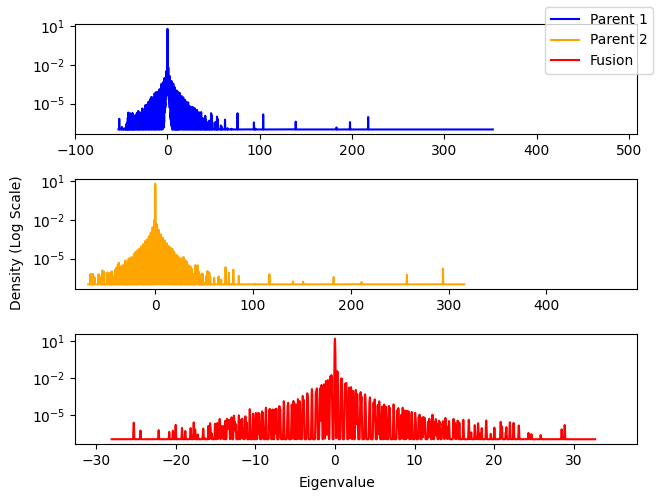

In [26]:
import numpy as np
fig, axs = plt.subplots(len(data))
fig.tight_layout(h_pad=2)
labels = ["Parent 1", "Parent 2", "Fusion"]
colors = ["blue", "orange", "red"]

for i, (model_k, model_v) in enumerate(data.items()):
    density_eigens = []
    density_weights = []
    for j, (batch_k, [density_eigen, density_weight]) in enumerate(model_v.items()): 
        density_eigens += density_eigen
        density_weights += density_weight
    density, grids = density_generate(density_eigens, density_weights)
    axs[i].semilogy(grids, density + 1.0e-7, color = colors[i], label= labels[i])
    axs[i].set(xlim=(np.min(density_eigens) - 1, np.max(density_eigens) + 1), ylim=(None, None))
fig.text(0.5, 0.0, 'Eigenvalue', ha='center', va='center')
fig.text(0.0, 0.5, 'Density (Log Scale)', ha='center', va='center', rotation='vertical')
fig.legend()
fig.tight_layout()
fig.savefig(f'./ev_density_plot.png',  bbox_inches='tight')